# Предсказывание
```
Создал: Рудницкий С.Ф.
Дата создания: 04.06.2022
Дата корректировки: 04.06.2022
```

In [1]:
#!pip install openpyxl

In [9]:
!#!pip install pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for pytorch, since package 'wheel' is not installed.
  Running setup.py install for pytorch: started
  Running setup.py install for pytorch: finished with status 'error'


  error: subprocess-exited-with-error
  
  Running setup.py install for pytorch did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\Сергей\AppData\Local\Temp\pip-install-1vhd9se7\pytorch_efdc9353e17a45468d53cfb1d24d7f3a\setup.py", line 11, in <module>
      raise Exception(message)
  Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: legacy-install-failure

Encountered error while trying to install package.

pytorch

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.


In [2]:
#!pip install statsmodels

In [5]:
def get_df_full():
    SOURCE_FILE = "Журнал активных вызовов 01.2020-05.2022 (исходник)"+".xlsx"
    dfl = pd.read_excel(SOURCE_FILE, index_col=0)
    dfs = dfl.loc[dfl['Подстанция'].isin(select_list)]
    dfs0 = dfs.groupby(['Подстанция','ДатаВызова']).agg({'День':'count'}).reset_index().set_index('ДатаВызова')
    dfs0.columns = ['Подстанция','Кол-во вызовов']
    return dfs0

df = get_df_full()
df.to_excel("Журнал активных вызовов (для предсказаний)"+".xlsx")


In [1]:
import pandas as pd

In [2]:
select_list = ['ПСМП №1', 'ПСМП №2', 'ПСМП №3', 'ПСМП №4', 'ПСМП №5', 'ПСМП №6', 'ПСМП №7', 'ПСМП №8', 'ПСМП №9']   

In [3]:
import os
def get_df():
    SOURCE_FILE = "Журнал активных вызовов (для предсказаний)"+".xlsx"
    dir_path = os.path.normpath("o:\!P\!P00_AI\Хакатон ПФО 2022\\"+SOURCE_FILE)
    dfl = pd.read_excel(dir_path)
    return dfl

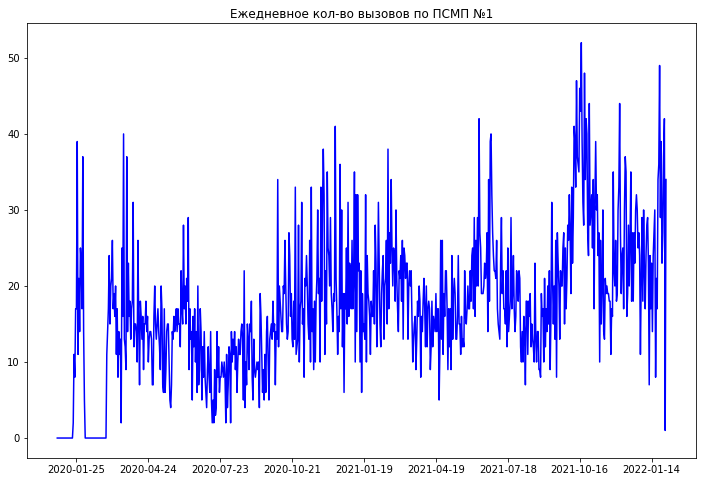

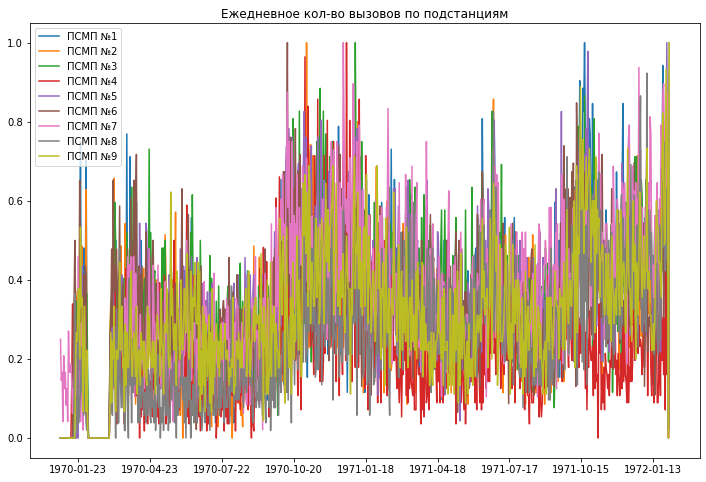

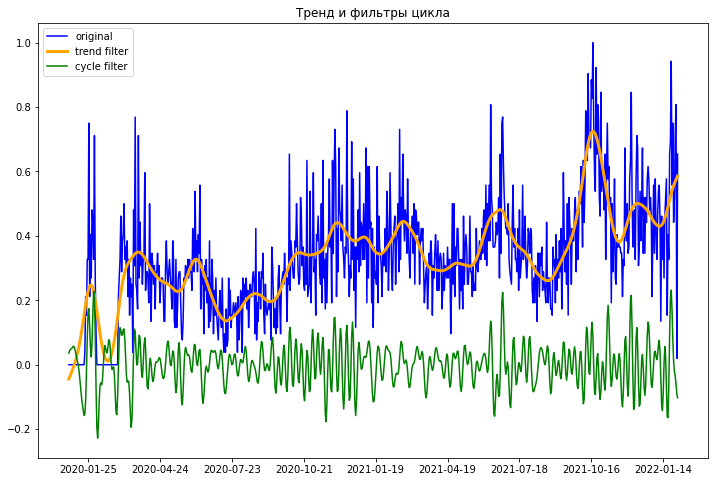

In [4]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm


df = get_df()
#print(df.head()) # RSF
date_fmt = '%Y-%m-%d'
start_date = datetime.datetime.strptime('2020-01-01', date_fmt)
end_date = datetime.datetime.strptime('2022-02-01', date_fmt)
date_list = pd.date_range(start_date, end_date)
#print(date_list)

dateDataset = pd.DataFrame(data=date_list)
dateDataset.columns=['ДатаВызова']
#print(dateDataset.head())

aus_confirmed = df[df['Подстанция'] == 'ПСМП №1'][['ДатаВызова','Кол-во вызовов']]
aus_confirmed_diff = dateDataset.merge(aus_confirmed, how='left').set_index('ДатаВызова').fillna(0)
aus_confirmed_diff['Кол-во вызовов'] = aus_confirmed_diff['Кол-во вызовов'].astype('float')

# Количество вызовов в день
#aus_confirmed_diff = df[df['Подстанция'] == 'ПСМП №1']['Кол-во вызовов'].fillna(0)
plt.figure(figsize=(12, 8)) # RSF
plt.title('Ежедневное кол-во вызовов по ПСМП №1')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 90))
plt.plot(date_list[:], aus_confirmed_diff, color = 'blue')
plt.show()

# Количество вызовов в день по каждой из подстанций

plt.figure(figsize=(12, 8)) # RSF
plt.title('Ежедневное кол-во вызовов по подстанциям')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 90))
for c in select_list:
    #plt.title(f'Кол-во вызовов')
    ts0 = df[df['Подстанция'] == c][['ДатаВызова','Кол-во вызовов']]
    ts = dateDataset.merge(ts0, how='left').set_index('ДатаВызова').fillna(0).values
    #ts = df[df['Country'] == c]['Confirmed'].diff().fillna(0).values
    ts = ts / max(ts)
    plt.plot(ts, label = c)
plt.legend()
plt.show()

# Дополнительный статистический инструмент
plt.figure(figsize=(12, 8)) # RSF
aus_confirmed_diff_norm = aus_confirmed_diff / max(aus_confirmed_diff['Кол-во вызовов'])
_, train_hp_trend = sm.tsa.filters.hpfilter(aus_confirmed_diff_norm)
train_cf_cycle, _ = sm.tsa.filters.cffilter(aus_confirmed_diff_norm)
plt.title('Тренд и фильтры цикла')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 90))
plt.plot(date_list[:], aus_confirmed_diff_norm, color = 'blue', label = 'original')
plt.plot(date_list[:], train_hp_trend, color = 'orange', label = 'trend filter', linewidth = 3)
plt.plot(date_list[:], train_cf_cycle, color = 'green', label = 'cycle filter')
plt.legend()
plt.show()


In [5]:
import copy

import numpy as np
import random
import torch
import torch.nn as nn
from torch import optim


class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)

    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.gru(flat)
        return out, h


class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, hidden_dl_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.lin1 = nn.Linear(hidden_size, hidden_dl_size)
        self.lin2 = nn.Linear(hidden_dl_size, output_size)

    def forward(self, x, h):
        out, h = self.gru(x.unsqueeze(0), h)
        y = torch.relu(self.lin1(out.squeeze(0)))
        y = self.lin2(y)
        return y, h


class EncoderDecoder(nn.Module):

    def __init__(self, hidden_size, hidden_dl_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = Decoder(input_size = output_size, hidden_size = hidden_size,
                               hidden_dl_size = hidden_dl_size, output_size = output_size)

    def train_model(
            self, train, target, val, val_target,
            epochs, target_len, method = 'recursive',
            tfr = 0.5, lr = 0.01, dynamic_tf = False
    ):
        losses = np.full(epochs, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.MSELoss()

        best_val_loss = 1000_000
        best_model_params = None

        for e in range(epochs):
            predicted = torch.zeros(target_len, train.shape[1], 1)
            optimizer.zero_grad()
            _, enc_h = self.encoder(train)

            dec_in = train[-1, :, 0].unsqueeze(1)
            dec_h = enc_h

            if method == 'recursive':
                for t in range(target_len):
                    dec_out, dec_h = self.decoder(dec_in, dec_h)
                    predicted[t] = dec_out
                    dec_in = dec_out

            if method == 'teacher_forcing':
                # use teacher forcing
                if random.random() < tfr:
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = target[t, :].unsqueeze(1)
                # predict recursively
                else:
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

            if method == 'mixed_teacher_forcing':
                # predict using mixed teacher forcing
                for t in range(target_len):
                    dec_out, dec_h = self.decoder(dec_in, dec_h)
                    predicted[t] = dec_out
                    # predict with teacher forcing
                    if random.random() < tfr:
                        dec_in = target[t, :].unsqueeze(1)
                    # predict recursively
                    else:
                        dec_in = dec_out

            loss = criterion(predicted.squeeze(2), target)
            loss.backward()
            optimizer.step()

            val_predicted = self.predict(val, val_target.size(0))
            val_loss = criterion(val_predicted.squeeze(2), val_target)

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_params = copy.deepcopy(self.state_dict())

            losses[e] = loss.item()

            if e % 10 == 0:
                print(f'Epoch {e}/{epochs}| '
                      f'test: {round(loss.item(), 4)}, '
                      f'val: {round(val_loss.item(), 4)}')

            # dynamic teacher forcing
            if dynamic_tf and tfr > 0:
                tfr = tfr - 0.02

        return best_model_params, best_val_loss

    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], 1)

        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, 0].unsqueeze(1)
        dec_h = enc_h

        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out

        return y


In [6]:
def sliding_window(ts, features, target_len = 1):
    X, Y = [], []
    for i in range(features + target_len, len(ts) + 1):
        X.append(ts[i - (features + target_len):i - target_len])
        Y.append(ts[i - target_len:i])
    return X, Y

In [9]:
import os
import random
import torch
import statsmodels.api as sm

def prepare_model(params, save_model = False, model_name = 'enc_dec'):
    # Глобальные параметры
    #dir_path = os.path.dirname(os.path.realpath(__file__))
    dir_path = os.path.normpath("o:\!P\!P00_AI\Хакатон ПФО 2022")
    df = get_df()
    #print(df.head())
    start_date = '2020-01-01'
    end_date = '2021-02-01'

    # размер скользящего окна
    w = 120
    # длина предсказания
    out = 60
    # Количество эпох
    epochs = 3_00

    # Гипер-параметры:
    hidden_size = params['hidden_size']
    hidden_dl_size = params['hidden_dl_size']
    lr = params['lr']
    tfr = params['tfr']

    # Подготовка датасета скользящего окна
    X, Y = [], []
    for c in select_list:
        ts_df0 = df[df['Подстанция'] == c][['ДатаВызова','Кол-во вызовов']].dropna()
        ts_df = ts0.set_index('ДатаВызова')
        #print(ts_df.head())
        train = ts_df[start_date:end_date].values
        # Нормализация временного ряда
        train = train / max(train)
        # Статистический пре-процессинг
        _, train_hp_trend = sm.tsa.filters.hpfilter(train)
        train_cf_cycle, _ = sm.tsa.filters.cffilter(train)

        D = []
        for i in range(len(train)):
            D.append([train[i], train_hp_trend[i], train_cf_cycle[i]])

        # ввод - вывод для подстанции
        X_c, Y_c = sliding_window(D, w, out)
        X.extend(X_c)
        Y.extend(Y_c)

    # Разбитие на обучение-валидацию
    X_train, Y_train = [], []
    X_val, Y_val = [], []
    for i in range(len(X)):
        if random.random() > .8:
            X_val.append(X[i])
            Y_val.append(Y[i])
        else:
            X_train.append(X[i])
            Y_train.append(Y[i])

    # Преобразование датасетов в тензоры
    #x_train = torch.tensor(X_train).float().transpose(0, 1)
    x_train = torch.from_numpy(np.array(X_train,dtype=np.float32)).transpose(0, 1)
    y_train = torch.from_numpy(np.array(Y_train,dtype=np.float32)).transpose(0, 1)[:, :, 0]
    x_val = torch.from_numpy(np.array(X_val,dtype=np.float32)).transpose(0, 1)
    y_val = torch.from_numpy(np.array(Y_val,dtype=np.float32)).transpose(0, 1)[:, :, 0]

    # Инициализация модели
    model_params = {
        'hidden_size':    hidden_size,
        'hidden_dl_size': hidden_dl_size,
        'input_size':     3,
        'output_size':    1
    }
    model = EncoderDecoder(**model_params)
    model.train()

    # Обучение и получение результатов
    model_params, val = model.train_model(
        x_train, y_train, x_val, y_val, epochs, out,
        method = 'mixed_teacher_forcing', tfr = tfr, lr = lr)

    # Saving the model if necessary
    if save_model:
        torch.save(model_params, f'{dir_path}/data/{model_name}.pth')

    return val


In [10]:
import random
import numpy as np
import torch

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# NNI result:
# Best trial params: {'hidden_size': 32, 'hidden_dl_size': 12, 'lr': 0.01, 'tfr': 0.1}
params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'lr':             .01,
    'tfr':            .1,
}

prepare_model(params, save_model = True, model_name = 'best_model')

Epoch 0/300| test: 0.6616, val: 0.537
Epoch 10/300| test: 0.0628, val: 0.0432
Epoch 20/300| test: 0.044, val: 0.0422
Epoch 30/300| test: 0.0433, val: 0.0421
Epoch 40/300| test: 0.0428, val: 0.042
Epoch 50/300| test: 0.0424, val: 0.042
Epoch 60/300| test: 0.0423, val: 0.0416
Epoch 70/300| test: 0.0407, val: 0.0402
Epoch 80/300| test: 0.0369, val: 0.0353
Epoch 90/300| test: 0.0328, val: 0.0321
Epoch 100/300| test: 0.0302, val: 0.0299
Epoch 110/300| test: 0.0286, val: 0.0281
Epoch 120/300| test: 0.0278, val: 0.0278
Epoch 130/300| test: 0.0269, val: 0.027
Epoch 140/300| test: 0.0266, val: 0.0264
Epoch 150/300| test: 0.0264, val: 0.0262
Epoch 160/300| test: 0.0262, val: 0.0261
Epoch 170/300| test: 0.026, val: 0.026
Epoch 180/300| test: 0.0259, val: 0.0258
Epoch 190/300| test: 0.0258, val: 0.0258
Epoch 200/300| test: 0.0256, val: 0.0256
Epoch 210/300| test: 0.0255, val: 0.0256
Epoch 220/300| test: 0.043, val: 0.0513
Epoch 230/300| test: 0.0438, val: 0.0426
Epoch 240/300| test: 0.0394, val: 0

0.025433866307139397

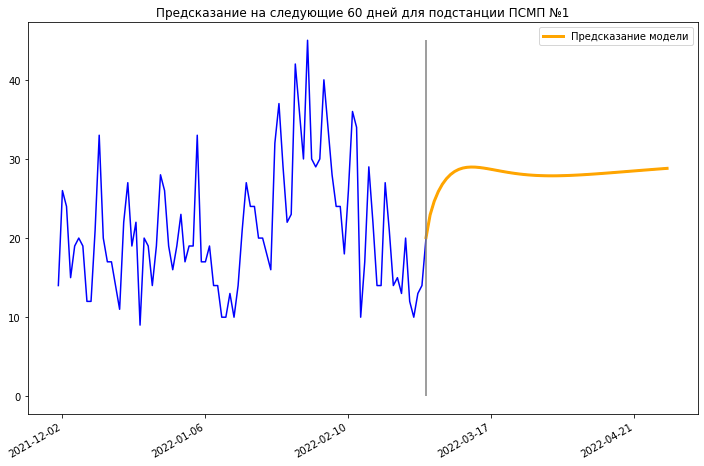

In [33]:
import datetime
import os
import datetime as dt
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Global parameters
#dir_path = os.path.dirname(os.path.realpath(__file__)) # RSF
dir_path = os.path.normpath("o:/!P/!P00_AI/Хакатон ПФО 2022/") # RSF
# Нама необходима только временная последовательность длиной 120
#from_date = '2021-10-04'
#to_date = '2022-02-01'
from_date = '2021-12-01'
to_date = '2022-03-01'

date_fmt = '%Y-%m-%d'
station = 'ПСМП №1'
df = get_df()

#au_ts_df = df[df['Подстанция'] == station]['Кол-во вызовов'].dropna()
#test = au_ts_df[from_date:to_date].values

au_ts_df0 = df[df['Подстанция'] == c][['ДатаВызова','Кол-во вызовов']].dropna()
au_ts_df = au_ts_df0.set_index('ДатаВызова')
test = au_ts_df[from_date:to_date].values

max_test = max(test)
test = test / max_test
test_hp_cycle, test_hp_trend = sm.tsa.filters.hpfilter(test)
test_cf_cycle, test_cf_trend = sm.tsa.filters.cffilter(test)
X = []
for i in range(len(test)):
    X.append([test[i], test_hp_trend[i], test_cf_cycle[i]])

#x = torch.tensor([X]).float().transpose(0, 1)
x = torch.from_numpy(np.array([X],dtype=np.float32)).transpose(0, 1)

# Initializing the model
model_name = 'best_model'
model_params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1
}

model = EncoderDecoder(**model_params)
model.load_state_dict(torch.load(f'{dir_path}/data/{model_name}.pth'))
model.eval()
predicted = model.predict(x, 60)

# Plotting the prediction
in_seq = [e * max_test for e in x[:, -1, 0].view(-1).tolist()]
pred_seq = [e * max_test for e in predicted[:, -1, 0].view(-1).tolist()]
x_axis = range(len(in_seq) + len(pred_seq))
start_date = datetime.datetime.strptime(from_date, date_fmt)
end_date = start_date + datetime.timedelta(days = len(in_seq))
prediction_date = start_date + datetime.timedelta(days = len(in_seq) + len(pred_seq))
date_list = mdates.drange(start_date, prediction_date, dt.timedelta(days = 1))

plt.figure(figsize=(12, 8)) # RSF
plt.title(f'Предсказание на следующие 60 дней для подстанции ПСМП №1')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 35))
plt.plot(date_list[:], in_seq + pred_seq, color = 'blue')
plt.plot(date_list[len(in_seq):],
         pred_seq,
         label = 'Предсказание модели',
         color = 'orange',
         linewidth = 3)
plt.vlines(end_date, 0, max_test, color = 'grey')
plt.legend(loc = "upper right")
plt.gcf().autofmt_xdate()
plt.show()


ValueError: x and y must have same first dimension, but have shapes (180,) and (181, 1)

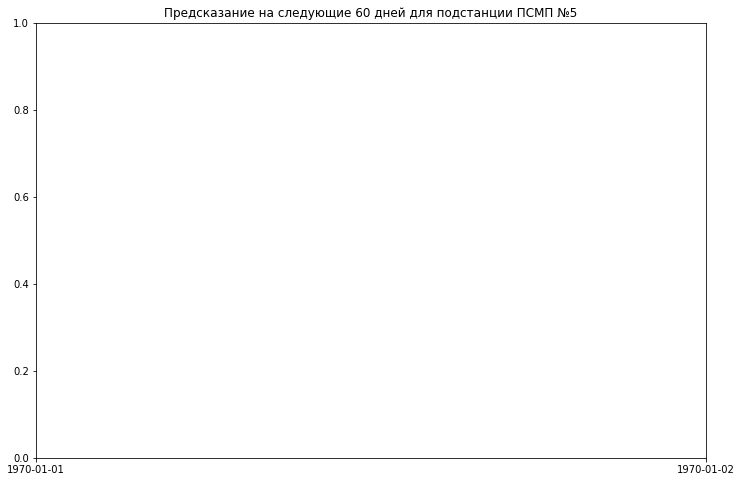

In [94]:
import datetime
import os
import datetime as dt
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#dir_path = os.path.dirname(os.path.realpath(__file__)) # RSF
dir_path = os.path.normpath("o:/!P/!P00_AI/Хакатон ПФО 2022/") # RSF

model_name = 'best_model'
model_params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1
}

model = EncoderDecoder(**model_params)
model.load_state_dict(torch.load(f'{dir_path}/data/{model_name}.pth'))
model.eval()
from_date = '2021-11-23'
to_date = '2022-05-22'
date_fmt = '%Y-%m-%d'
station = 'ПСМП №5'
df = get_df()
au_ts_df0 = df[df['Подстанция'] == station][['ДатаВызова','Кол-во вызовов']].dropna()
au_ts_df = au_ts_df0.set_index('ДатаВызова')
ts = au_ts_df[from_date:to_date].values
test = ts[:120]
au_ts_df
max_test = max(test)
test = test / max_test
test_hp_cycle, test_hp_trend = sm.tsa.filters.hpfilter(test)
test_cf_cycle, test_cf_trend = sm.tsa.filters.cffilter(test)
X = []
for i in range(len(test)):
    X.append([test[i], test_hp_trend[i], test_cf_cycle[i]])

#x = torch.tensor([X]).float().transpose(0, 1)
x = torch.from_numpy(np.array([X],dtype=np.float32)).transpose(0, 1)
model.eval()
predicted = model.predict(x, 60)
#print(len(predicted))

in_seq = [e * max_test for e in x[:, -1, 0].view(-1).tolist()]
target_seq = list(ts[120:])
pred_seq = [e * max_test for e in predicted[:, -1, 0].view(-1).tolist()]
x_axis = range(len(in_seq) + len(pred_seq))
start_date = datetime.datetime.strptime(from_date, date_fmt)
end_date = start_date + datetime.timedelta(days = len(in_seq))
prediction_date = start_date + datetime.timedelta(days = len(in_seq) + len(pred_seq))
date_list = mdates.drange(start_date, prediction_date, dt.timedelta(days = 1))
#date_list = pd.date_range(start_date, prediction_date)

plt.figure(figsize=(12, 8)) # RSF
plt.title(f'Предсказание на следующие 60 дней для подстанции {station}')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 35))
plt.plot(date_list[:], in_seq + target_seq, color = 'blue')
plt.plot(date_list[len(in_seq):],
         pred_seq,
         label = 'Предсказание модели',
         color = 'orange',
         linewidth = 3)
plt.vlines(end_date, 0, max_test, color = 'grey')
plt.legend(loc = "upper right")
plt.gcf().autofmt_xdate()
plt.show()


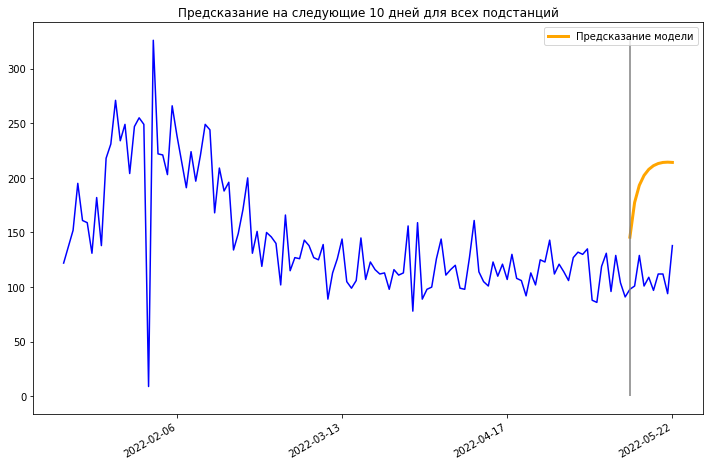

In [92]:
import datetime
import os
import datetime as dt
import torch
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#dir_path = os.path.dirname(os.path.realpath(__file__)) # RSF
dir_path = os.path.normpath("o:/!P/!P00_AI/Хакатон ПФО 2022/") # RSF

model_name = 'best_model'
model_params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1
}

model = EncoderDecoder(**model_params)
model.load_state_dict(torch.load(f'{dir_path}/data/{model_name}.pth'))
model.eval()
from_date = '2022-01-12'
to_date = '2022-05-22'
date_fmt = '%Y-%m-%d'
station = 'ПСМП №1'
df = get_df()
au_ts_df0 = df[['ДатаВызова','Кол-во вызовов']].dropna()
au_ts_df = au_ts_df0.groupby(['ДатаВызова']).agg({'Кол-во вызовов':'sum'}).reset_index().set_index('ДатаВызова')
#print(au_ts_df.head())
#au_ts_df = au_ts_df0.set_index('ДатаВызова')
ts = au_ts_df[from_date:to_date].values
test = ts[:120]
au_ts_df
max_test = max(test)
test = test / max_test
test_hp_cycle, test_hp_trend = sm.tsa.filters.hpfilter(test)
test_cf_cycle, test_cf_trend = sm.tsa.filters.cffilter(test)
X = []
for i in range(len(test)):
    X.append([test[i], test_hp_trend[i], test_cf_cycle[i]])

#x = torch.tensor([X]).float().transpose(0, 1)
x = torch.from_numpy(np.array([X],dtype=np.float32)).transpose(0, 1)
model.eval()
predicted = model.predict(x, 10)
#print(len(predicted))

in_seq = [e * max_test for e in x[:, -1, 0].view(-1).tolist()]
target_seq = list(ts[120:])
pred_seq = [e * max_test for e in predicted[:, -1, 0].view(-1).tolist()]
x_axis = range(len(in_seq) + len(pred_seq))
start_date = datetime.datetime.strptime(from_date, date_fmt)
end_date = start_date + datetime.timedelta(days = len(in_seq))
prediction_date = start_date + datetime.timedelta(days = len(in_seq) + len(pred_seq))
date_list = mdates.drange(start_date, prediction_date, dt.timedelta(days = 1))
#date_list = pd.date_range(start_date, prediction_date)

plt.figure(figsize=(12, 8)) # RSF
plt.title(f'Предсказание на следующие 10 дней для всех подстанций')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 35))
plt.plot(date_list[:], in_seq + target_seq, color = 'blue')
plt.plot(date_list[len(in_seq):],
         pred_seq,
         label = 'Предсказание модели',
         color = 'orange',
         linewidth = 3)
plt.vlines(end_date, 0, max_test, color = 'grey')
plt.legend(loc = "upper right")
plt.gcf().autofmt_xdate()
plt.show()